In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    make_scorer,
    precision_recall_curve,
    precision_score,
    r2_score,
    recall_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.svm import SVC, SVR

from confusion_matrix import plot_confusion_matrix

In [2]:
# Plots stuff
from pylab import rcParams

rcParams['figure.figsize'] = 16, 16
%matplotlib inline

sns.set()

plt.rcParams['figure.dpi'] = 100

In [3]:
random_seed = 2512
random_state = np.random.RandomState(random_seed)

# Loading and preparing data

In [4]:
OUTCOMES = ['Significant_bleeding_outcome', 'Stroke_outcome', 'Death_and_renal_failure', 'Death_inhosp',]
AMBIGUOUS_COLUMNS = ['PRU_more208', 'PRU_less95', 'C_rivar_137', ]
STRING_COLUMNS = ['AF_type', 'Stent_type', 'CYP4F2', 'P2Y12'] # These columns should be encoded with LabelEncoder
MAX_PRU = 208 # Maximum and minimum PRU borders, lower and higher is an unsafe zone
MIN_PRU = 95
UNNEEDED_COLUMNS = [
    'Agr_Platelets_Cat',
    'Residual_more230',
    'Residual_reactivity_less85',
    'CrusadeScore_bleeding',
    'Acatalepsia',
    'Gastric',
]
NUMERIC_COLUMNS = [
    'Age',
    'GFR',
    'PRU',
    'Rivaroxaban_C_blood',
    'inhibition',
    'CRUSADE',
    'SYNTAX_score',
    'Hb',
    'CHA2DS2VASC',
    'Hasbled',
    'Agr_Platelets_base',
    'Rivaroxaban_dose',
]

In [5]:
df = pd.read_csv('Rivaroxaban_fg.csv', header=0, index_col=0)[:103]

SINGLE_VALUE_COLUMNS = [col for col in df.columns if len(df[col].unique()) == 1]
SUSPICIOUS_MISSING_VALUES_COLUMNS = [col for col in df.columns if '-999' in df[col].unique()]
BINARY_COLUMNS = [col for col in df.columns if len(df[col].unique()) == 2]

df = df.drop([*UNNEEDED_COLUMNS, *SINGLE_VALUE_COLUMNS], axis=1)

for outcome in OUTCOMES:
    df[outcome] = df[outcome].replace(' ', 0).astype(float)

for numeric_col in NUMERIC_COLUMNS:
    df[numeric_col] = df[numeric_col].astype(float)

for category_col in STRING_COLUMNS:
    encoder = LabelEncoder()
    df[category_col + '_encoded'] = encoder.fit_transform(df[category_col])
    

In [6]:
BINARY_VALUES_COLUMNS = [col for col in df.columns if len(df[col].unique()) == 2]
BINARY_VALUES_COLUMNS

['Sex',
 'PRU_more208',
 'PRU_less95',
 'C_rivar_137',
 'STEMI',
 'NSTEMI',
 'Unstableangina',
 'PCI',
 'Death_inhosp',
 'Obesity',
 'Alcohol',
 'Smoking',
 'Cardiosclerosis',
 'Previous_PCI',
 'PreviousCABG',
 'HighriskSYNTAX',
 'Grace_score_risk',
 'Heart_Stop',
 'Hypertension',
 'HeartFailure_before',
 'Stroke',
 'Previous_thromboses',
 'Diabetes',
 'PAD',
 'COPD',
 'Onco',
 'Previous_bleeding',
 'Anaemialessthan100',
 'Plateletslessthan100',
 'Highplateletsondischarge',
 'Death_and_renal_failure',
 'RenalFailure',
 'HeartFailure',
 'HasBLED39',
 'DAPT_TAPT',
 'Significant_bleeding_outcome',
 'Stroke_outcome',
 'CYP3A4_22',
 'CYP3A5_3_A6986G',
 'ABCB1_3435_Short',
 'ABCB1_rs4148738_Short',
 'CYP2C19_2_Short',
 'CYP2C19_17_Short',
 'CES1',
 'CYP3A4_2242480',
 'PON1',
 'IGTB3',
 'PEAR1_rs41273215']

In [7]:
SUSPICIOUS_MISSING_VALUES_COLUMNS

['Access', 'Stent_quant', 'SYNTAX_score']

# Initial analysis

In [8]:
SINGLE_VALUE_COLUMNS

['Thrombosysis', 'CYP2C19_3_G636A']

In [9]:
df.head()

,Sex,Age,Rivaroxaban_C_blood,Agr_Platelets_base,inhibition,PRU,PRU_more208,PRU_less95,C_rivar_137,STEMI,...,CES1,CYP3A4_2242480,PON1,IGTB3,P2Y12,PEAR1_rs41273215,AF_type_encoded,Stent_type_encoded,CYP4F2_encoded,P2Y12_encoded
Number,,,,,,,,,,,,,,,,,,,,,
1,1,81.0,204.0,195.0,48.0,102.0,2,2,1,0,...,1,1,2,1,1,1,2,2,2,1
2,1,88.0,134.0,196.0,28.0,141.0,2,2,0,0,...,1,1,2,2,1,1,2,0,1,1
3,1,81.0,242.0,211.0,13.0,183.0,2,2,1,0,...,2,1,2,1,2,2,2,3,2,2
4,0,73.0,57.0,163.0,12.0,144.0,2,2,0,0,...,2,1,2,2,2,2,1,3,2,2
5,0,61.0,37.0,182.0,11.0,162.0,2,2,0,0,...,1,1,2,1,2,1,1,3,2,2


In [10]:
df.columns

Index(['Sex', 'Age', 'Rivaroxaban_C_blood', 'Agr_Platelets_base', 'inhibition',
       'PRU', 'PRU_more208', 'PRU_less95', 'C_rivar_137', 'STEMI', 'NSTEMI',
       'Unstableangina', 'PCI', 'AF_type', 'Death_inhosp', 'Obesity',
       'Alcohol', 'Smoking', 'Cardiosclerosis', 'Previous_PCI', 'PreviousCABG',
       'Access', 'Stent_type', 'Stent_quant', 'HighriskSYNTAX',
       'Grace_score_risk', 'SYNTAX_score', 'CRUSADE', 'Killip', 'Heart_Stop',
       'Hypertension', 'HeartFailure_before', 'Stroke', 'Previous_thromboses',
       'Diabetes', 'PAD', 'COPD', 'Onco', 'Previous_bleeding',
       'Anaemialessthan100', 'Plateletslessthan100',
       'Highplateletsondischarge', 'Death_and_renal_failure', 'RenalFailure',
       'HeartFailure', 'HasBLED39', 'DAPT_TAPT', 'Hb', 'GFR', 'CHA2DS2VASC',
       'Hasbled', 'duration_months', 'Rivaroxaban_dose',
       'Significant_bleeding_outcome', 'Stroke_outcome', 'CYP3A4_22',
       'ABCB1_С3435Т', 'ABCB1_СТrs4148738', 'CYP2C19_2_G681A',
       'CYP

Text(0.5, 1.0, 'Data points distribution by Sex')

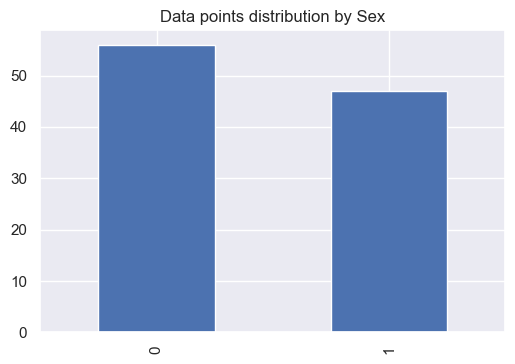

In [11]:
ax = df.Sex.value_counts().plot(kind='bar')
ax.set_title('Data points distribution by Sex')

Text(0.5, 1.0, 'Age distribution')

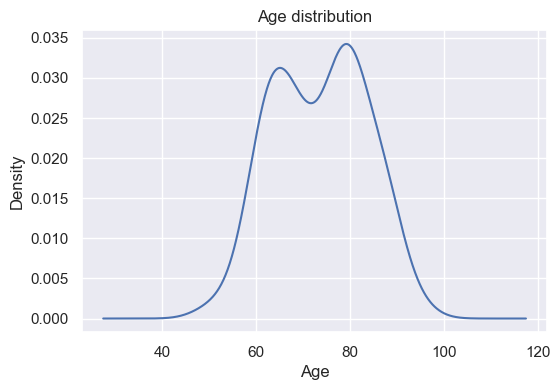

In [12]:
fig, ax = plt.subplots()
df.Age.plot(kind='kde')
ax.set_xlabel('Age')
ax.set_title('Age distribution')

Text(0.5, 1.0, 'Rivaroxaban_C_blood distribution')

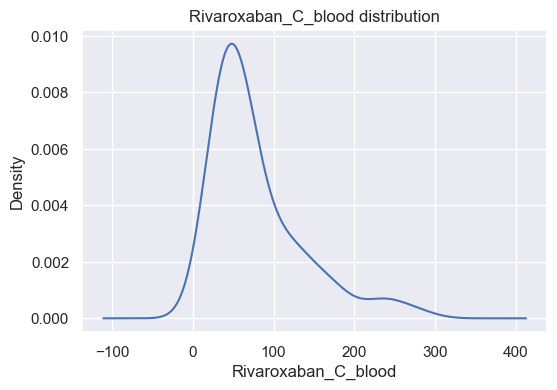

In [13]:
fig, ax = plt.subplots()
df.Rivaroxaban_C_blood.plot(kind='kde')
ax.set_xlabel('Rivaroxaban_C_blood')
ax.set_title('Rivaroxaban_C_blood distribution')

Text(0.5, 1.0, 'Agr_Platelets_base distribution')

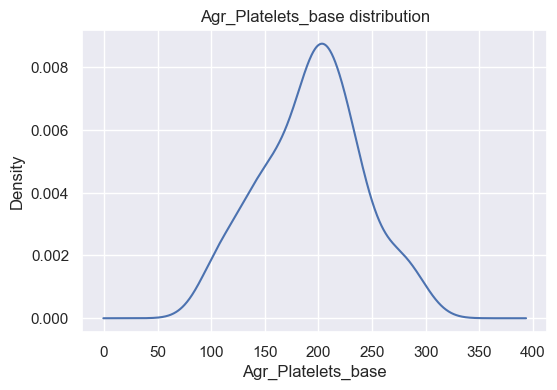

In [14]:
fig, ax = plt.subplots()
df.Agr_Platelets_base.plot(kind='kde')
ax.set_xlabel('Agr_Platelets_base')
ax.set_title('Agr_Platelets_base distribution')

Text(0.5, 1.0, 'GFR distribution')

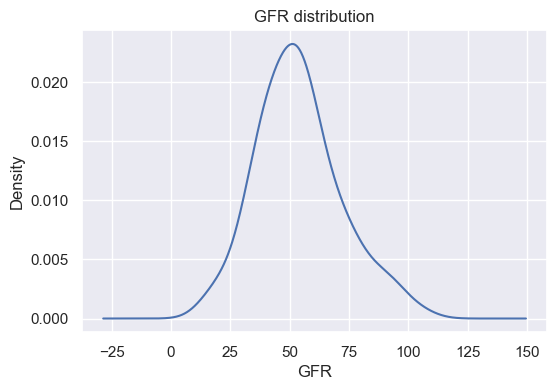

In [15]:
fig, ax = plt.subplots()
df.GFR.plot(kind='kde')
ax.set_xlabel('GFR')
ax.set_title('GFR distribution')

Text(0.5, 1.0, 'PRU distribution')

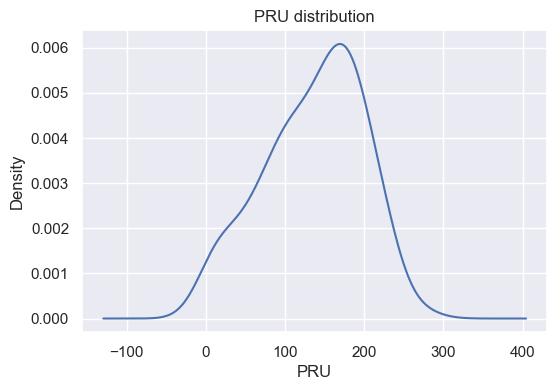

In [16]:
fig, ax = plt.subplots()
df.PRU.plot(kind='kde')
ax.set_xlabel('PRU')
ax.set_title('PRU distribution')

## Outcomes barplots

In [17]:
df_outcomes = df[
    [
        col for col in df.columns
        if not col in [
            *OUTCOMES,
            *STRING_COLUMNS,
            *AMBIGUOUS_COLUMNS,
        ]
    ]
]
df_outcomes = df_outcomes.replace(' ', 0)

def _process_row_outcomes(row):
    possible_outcomes = [outcome for outcome in OUTCOMES if row[outcome]]
    if not possible_outcomes:
        return 'Survived'
    elif len(possible_outcomes) == 1:
        return possible_outcomes[0].replace('_', ' ')
    elif (
        'Significant_bleeding_outcome' in possible_outcomes and
        'Death_and_renal_failure' in possible_outcomes
    ):
        return 'Death renal failure bleeding' # Maybe later we'll have enough data points to consider this outcome
    elif (
        'Significant_bleeding_outcome' in possible_outcomes and
        'Death_inhosp' in possible_outcomes
    ):
        return 'Death in hospital bleeding' # Maybe later we'll have enough data points to consider this outcome
    else:
        return 'Death and renal failure'

df_outcomes['Outcome'] = df.apply(
    _process_row_outcomes,
    axis = 1
)


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

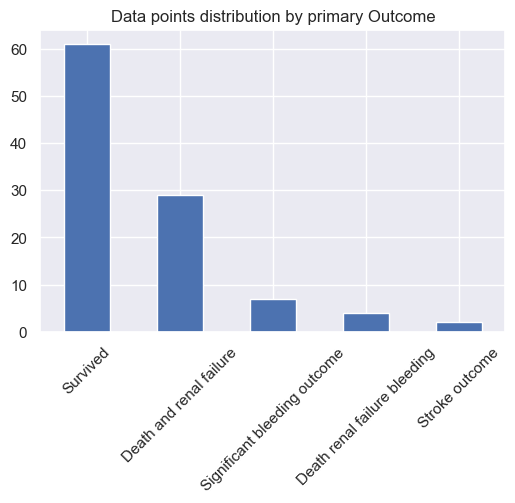

In [18]:
ax = df_outcomes.Outcome.value_counts().plot(kind='bar')
ax.set_title('Data points distribution by primary Outcome')
plt.xticks(rotation=45)

# Task number 1

Concentration prediction

Target columns -> `'Significant_bleeding_outcome', 'Stroke_outcome', 'Death_and_renal_failure', 'Death_inhosp'`


## [Survived/Died] classification - using LOOCV

### Data preparation

In [19]:
preprocessed_classification_df = df[
    [
        col for col in df.columns
        if not col in [
            *OUTCOMES,
            *STRING_COLUMNS,
            *AMBIGUOUS_COLUMNS,
        ]
    ]
]
preprocessed_classification_df = preprocessed_classification_df.replace(' ', 0)

In [20]:
df2=preprocessed_classification_df.copy(deep=True)

### Outcome column generation

In [21]:
def _process_row_outcomes(row):
    possible_outcomes = [outcome for outcome in OUTCOMES if row[outcome]]
    if not possible_outcomes:
        return 'Survived'
    elif len(possible_outcomes) == 1:
        return possible_outcomes[0]
    elif (
        'Significant_bleeding_outcome' in possible_outcomes and
        'Death_and_renal_failure' in possible_outcomes
    ):
        return 'Death_renal_failure_bleeding' # Maybe later we'll have enough data points to consider this outcome
    elif (
        'Significant_bleeding_outcome' in possible_outcomes and
        'Death_inhosp' in possible_outcomes
    ):
        return 'Death_in_hospital_bleeding' # Maybe later we'll have enough data points to consider this outcome
    else:
        return 'Death_renal_failure_inhosp'


def process_row_outcomes(row):
    outcome = _process_row_outcomes(row)
    if 'Death' in outcome: # TODO Discuss
        return 'Death'
    elif (
        outcome == 'Significant_bleeding_outcome' or 
        outcome == 'Stroke_outcome'
    ):
#         return 'Bleeding_or_stroke'
        return 'Survived'
    return outcome




df2['Outcome'] = df.apply(
    process_row_outcomes,
    axis = 1
)

encoder = LabelEncoder()
df2['Outcome_encoded'] = encoder.fit_transform(df2.Outcome)
X = df2[[col for col in df2.columns if not col.startswith('Outcome')]]
Y = df2['Outcome_encoded']
CLASS_NAMES = encoder.classes_

### Testing models using all features

In [22]:
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression

def evaluate_with_conf_matrix_loocv(model, X, Y, model_name, class_names):
    ##### LOOCV MODEL EVALUATION AND CONFUSION MATRIX PLOT
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    predictions = []


    for train, test in loo.split(X):
        predictions.append(model.fit(X.iloc[train], Y.iloc[train]).predict(X.iloc[test])[0])

    predictions = pd.Series(predictions)

    with sns.axes_style("darkgrid", {"axes.grid": False}):
        plot_confusion_matrix(
            Y,
            predictions,
            classes=class_names,
            normalize=False,
            title=f'Confusion matrix for {model_name}'
        )

        
def plot_important_features(X, coefficients, name, normalize=True):
    ##### TOP MOST IMPORTANT FEATURES PLOT

    N_to_print = min(20, X.shape[1]) # Plot up to 20 most important features
    y_pos = range(N_to_print)
    fig, ax = plt.subplots()
    plt.figure(figsize=(10,7))

    feature_importance = coefficients.round(4)
    feature_importance = zip(X.keys(), feature_importance)
    feature_importance = np.array(sorted(
        map(
            lambda pair: pair[1] != abs(pair[1]) and ('[negative]' + pair[0], abs(pair[1])) or (pair[0], pair[1]),
            feature_importance
        ),
        key=lambda x:x[1], reverse=True))
    ax.barh(y_pos, feature_importance[:N_to_print, 1].astype('float'), align='center', color='green')
    ax.set_yticks(np.arange(N_to_print))
    ax.set_yticklabels(feature_importance[:N_to_print, 0])
    ax.invert_yaxis()
    ax.set_xlabel(f'Importance/coefficients for {name}')

    plt.show()

################################### SVC ###################################
Confusion matrix, without normalization
[[31  2]
 [ 0 70]]


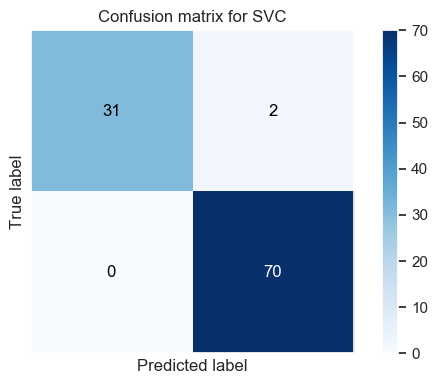

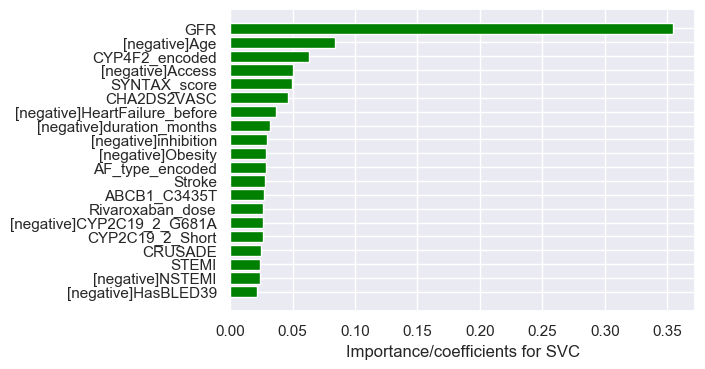

<Figure size 1000x700 with 0 Axes>

################################### Logistic Regression ###################################
Confusion matrix, without normalization
[[33  0]
 [ 1 69]]


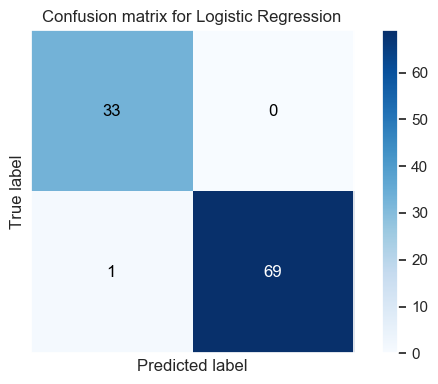

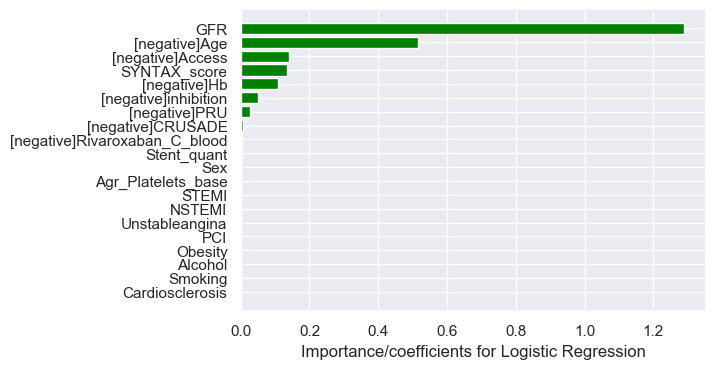

<Figure size 1000x700 with 0 Axes>

In [23]:
rf = RandomForestClassifier(n_jobs=6, n_estimators=50, random_state=random_state)
svc = SVC(kernel='linear', random_state=random_state)
log_reg = LogisticRegression(random_state=random_state, penalty='l1', solver='liblinear') # Use LASSO regularizer
for name, model in [
#     ['Random Forest', rf],
    ['SVC', svc],
    ['Logistic Regression', log_reg],
]:
    print(f'{"#"*35} {name} {"#"*35}')
    evaluate_with_conf_matrix_loocv(model, X, Y, name, CLASS_NAMES,)
    plot_important_features(
        X,
        model.coef_[0] if name != 'Random Forest' else model.feature_importances_,
        name,
    )




### Removing insignificant variables

In [24]:
transforming_model = SelectFromModel(log_reg, prefit=True)
X_transformed = transforming_model.transform(X)
feature_idx = transforming_model.get_support()
feature_names = X.columns[feature_idx]
X_transformed = pd.DataFrame(X_transformed, columns=X.columns[feature_idx])


In [25]:
feature_names

Index(['Age', 'Rivaroxaban_C_blood', 'inhibition', 'PRU', 'Access',
       'Stent_quant', 'SYNTAX_score', 'CRUSADE', 'Hb', 'GFR'],
      dtype='object')

### Testing models using only significant columns

################################### Random Forest ###################################
Confusion matrix, without normalization
[[33  0]
 [ 0 70]]


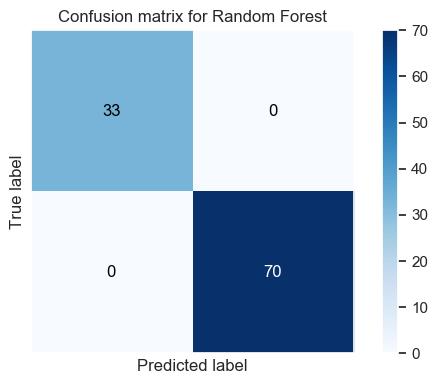

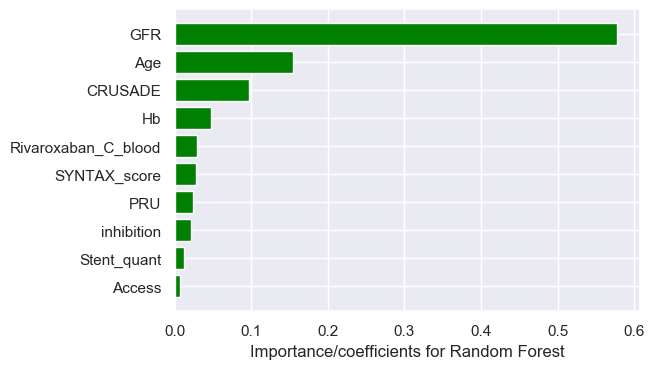

<Figure size 1000x700 with 0 Axes>

################################### SVC ###################################
Confusion matrix, without normalization
[[33  0]
 [ 1 69]]


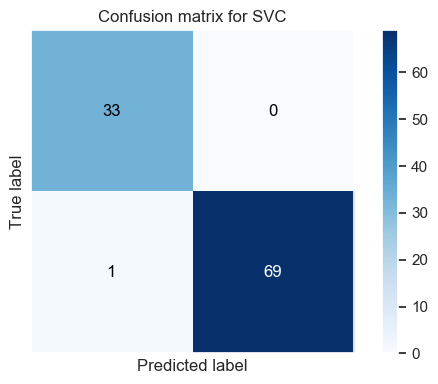

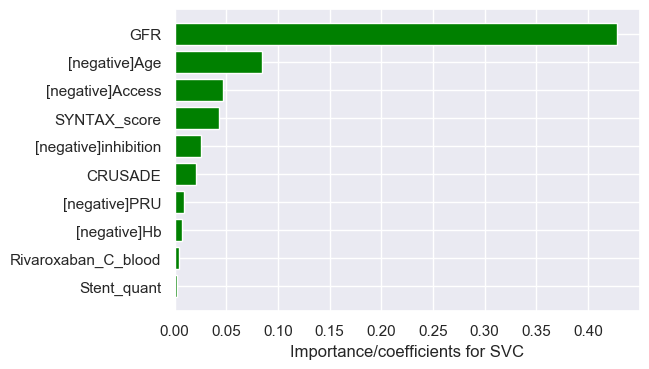

<Figure size 1000x700 with 0 Axes>

################################### Logistic Regression ###################################


/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear f

Confusion matrix, without normalization
[[33  0]
 [ 1 69]]


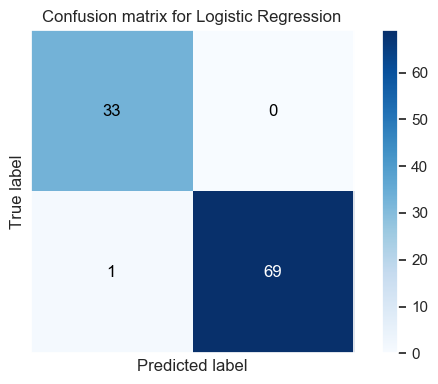

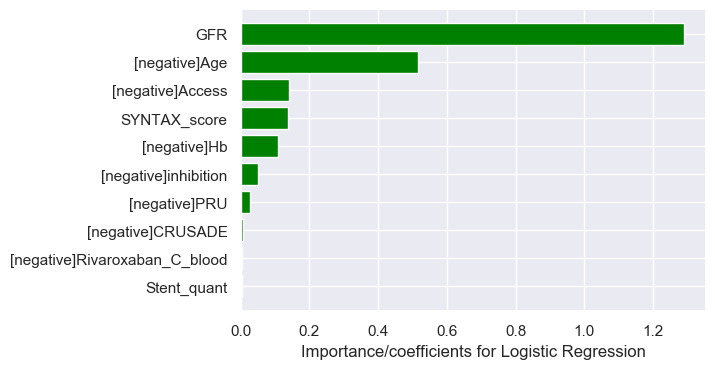

<Figure size 1000x700 with 0 Axes>

In [26]:
for name, model in [
    ['Random Forest', rf],
    ['SVC', svc],
    ['Logistic Regression', log_reg],
]:
    print(f'{"#"*35} {name} {"#"*35}')
    evaluate_with_conf_matrix_loocv(model, X_transformed, Y, name, CLASS_NAMES,)
    plot_important_features(
        X_transformed,
        model.coef_[0] if 'Random Forest' not in name else model.feature_importances_,
        name,
    )



### Running models without GFR variable

################################### Random Forest ###################################
Confusion matrix, without normalization
[[18 15]
 [ 8 62]]


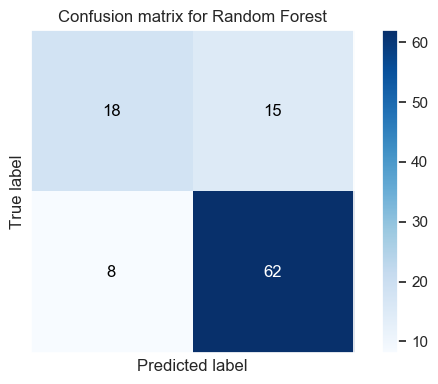

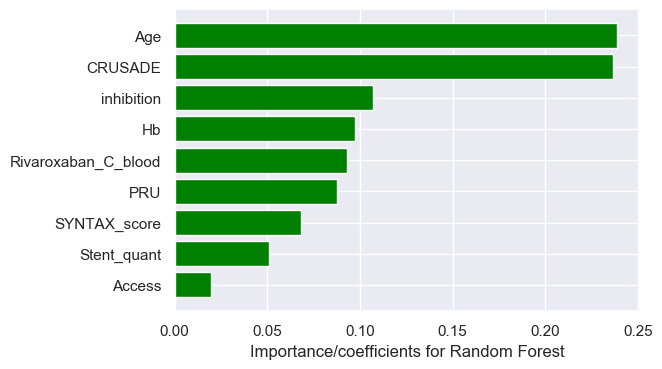

<Figure size 1000x700 with 0 Axes>

################################### SVC ###################################
Confusion matrix, without normalization
[[22 11]
 [12 58]]


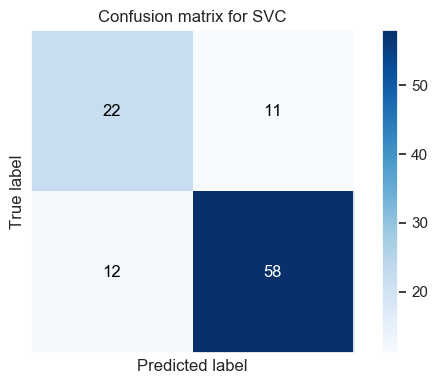

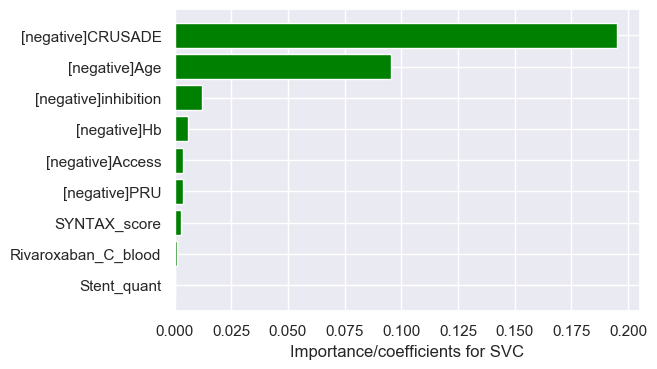

<Figure size 1000x700 with 0 Axes>

################################### Logistic Regression ###################################
Confusion matrix, without normalization
[[18 15]
 [13 57]]


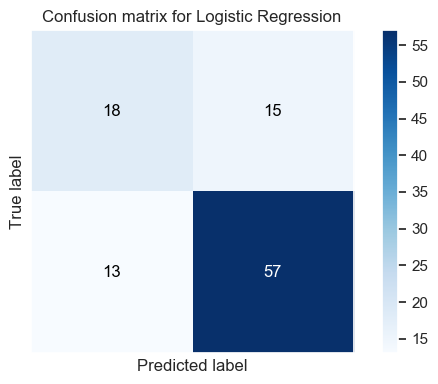

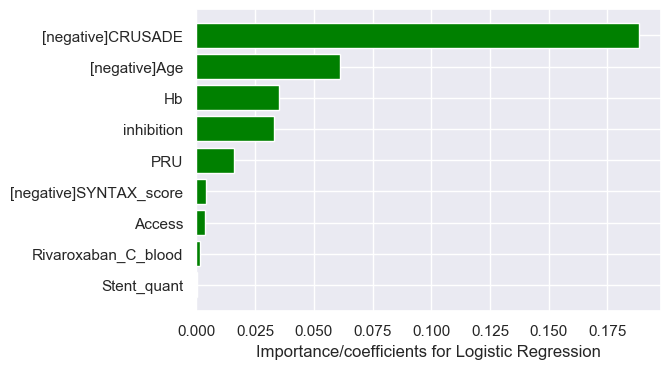

<Figure size 1000x700 with 0 Axes>

In [27]:
X_no_gfr = X_transformed.drop('GFR', axis=1)

for name, model in [
    ['Random Forest', rf],
    ['SVC', svc],
    ['Logistic Regression', log_reg],
]:
    print(f'{"#"*35} {name} {"#"*35}')
    evaluate_with_conf_matrix_loocv(model, X_no_gfr, Y, name, CLASS_NAMES,)
    plot_important_features(
        X_no_gfr,
        model.coef_[0] if name != 'Random Forest' else model.feature_importances_,
        name,
    )



### Running models with only GFR and Age variables

################################### Random Forest ###################################
Confusion matrix, without normalization
[[33  0]
 [ 0 70]]


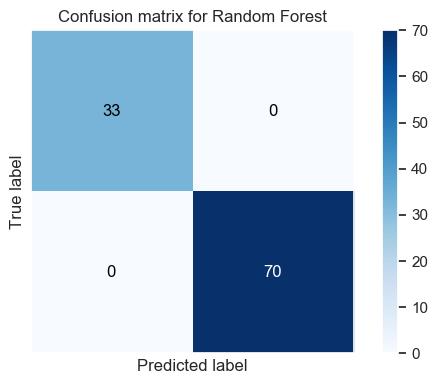

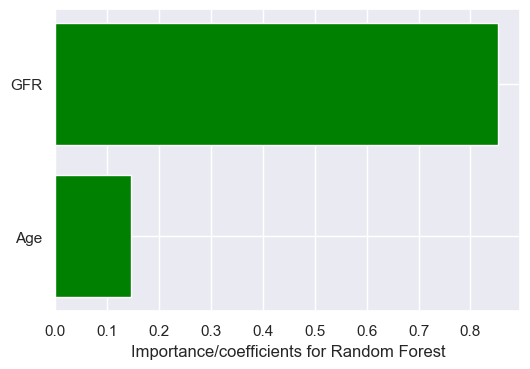

<Figure size 1000x700 with 0 Axes>

################################### SVC ###################################
Confusion matrix, without normalization
[[33  0]
 [ 0 70]]


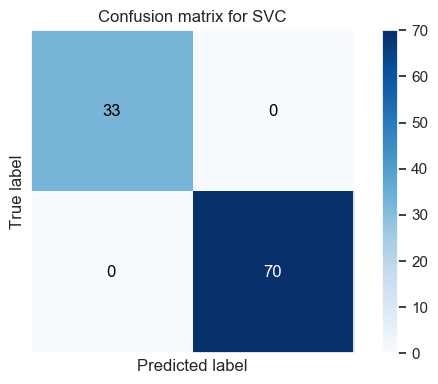

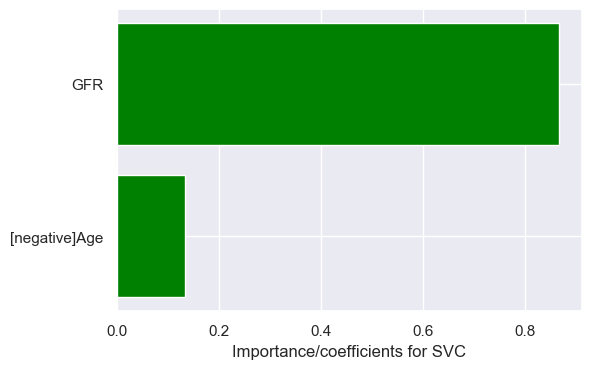

<Figure size 1000x700 with 0 Axes>

################################### Logistic Regression ###################################


/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear f

/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear f

Confusion matrix, without normalization
[[32  1]
 [ 1 69]]


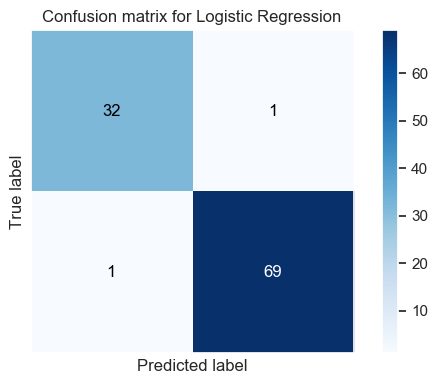

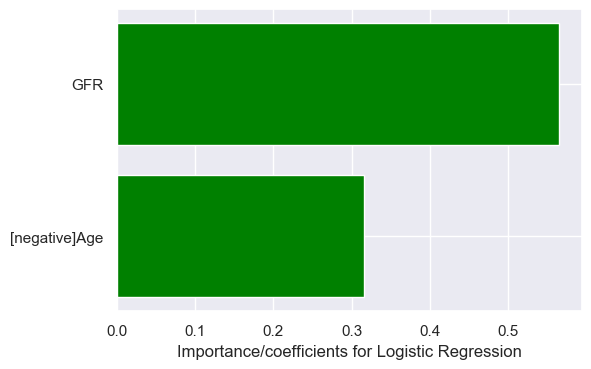

<Figure size 1000x700 with 0 Axes>

In [28]:
X_age_gfr = X_transformed[['GFR', 'Age']]

for name, model in [
    ['Random Forest', rf],
    ['SVC', svc],
    ['Logistic Regression', log_reg],
]:
    print(f'{"#"*35} {name} {"#"*35}')
    evaluate_with_conf_matrix_loocv(model, X_age_gfr, Y, name, CLASS_NAMES,)
    plot_important_features(
        X_age_gfr,
        model.coef_[0] if name != 'Random Forest' else model.feature_importances_,
        name,
    )



## [Bleeding/No bleeding] classification - using LOOCV

### Outcome column generation

In [29]:
df5 = preprocessed_classification_df.copy(deep=True)

df5['Outcome'] = df.Significant_bleeding_outcome.astype(int)


X = df5.drop('Outcome', axis=1)
Y = df5['Outcome']
CLASS_NAMES = np.array(['No bleeding', 'Bleeding'])

In [30]:
Y.unique(), CLASS_NAMES

(array([0, 1]), array(['No bleeding', 'Bleeding'], dtype='<U11'))

(array([0, 1]), <a list of 2 Text xticklabel objects>)

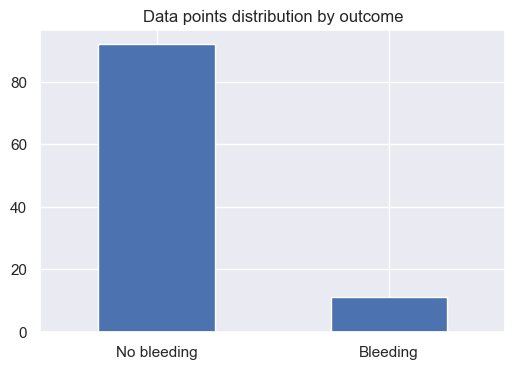

In [31]:
ax = df5.Outcome.value_counts().plot(kind='bar')
ax.set_xticklabels(CLASS_NAMES)
ax.set_title('Data points distribution by outcome')
plt.xticks(rotation=0)

### Evaluating models

################################### Random Forest ###################################
Confusion matrix, without normalization
[[92  0]
 [11  0]]


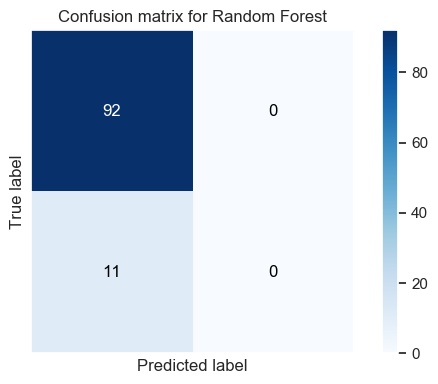

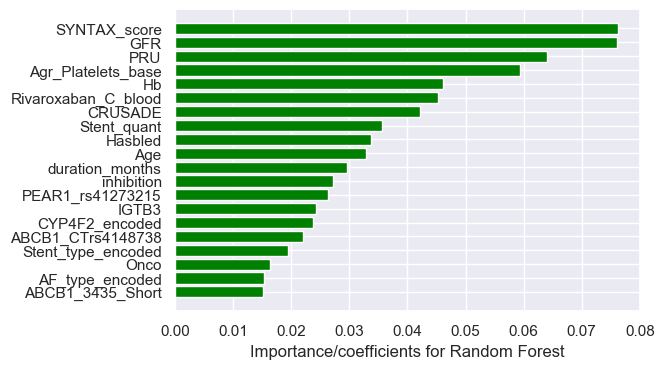

<Figure size 1000x700 with 0 Axes>

################################### SVC ###################################
Confusion matrix, without normalization
[[81 11]
 [ 9  2]]


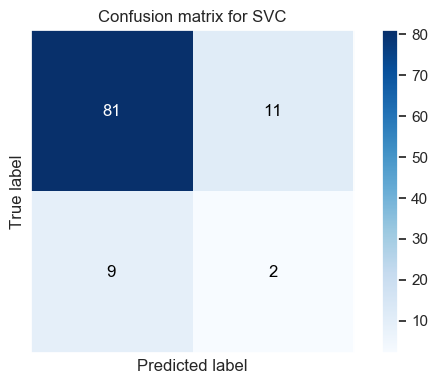

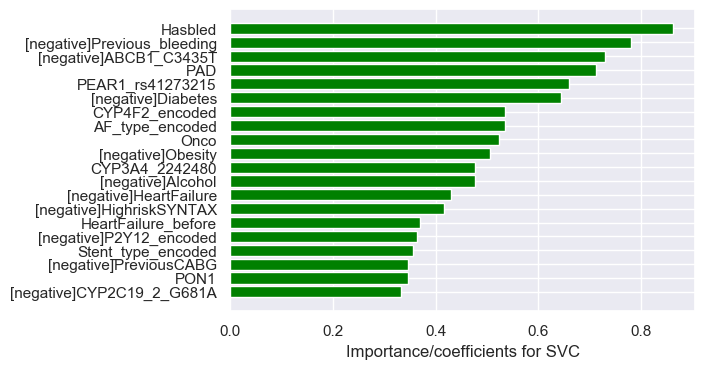

<Figure size 1000x700 with 0 Axes>

################################### Logistic Regression ###################################
Confusion matrix, without normalization
[[84  8]
 [10  1]]


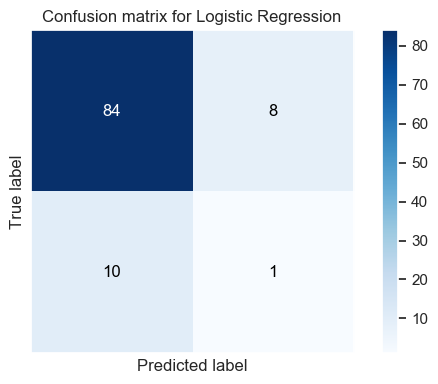

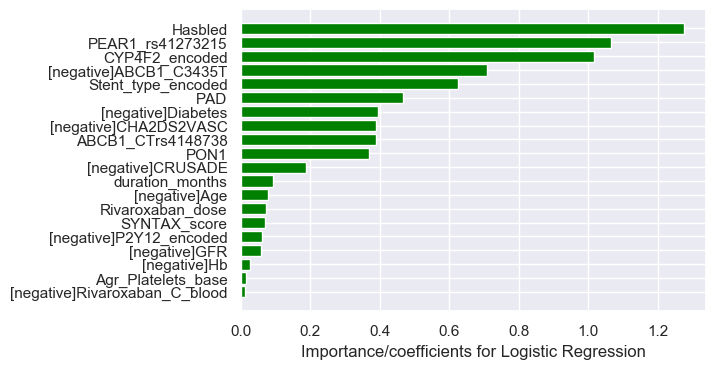

<Figure size 1000x700 with 0 Axes>

In [32]:
rf = RandomForestClassifier(n_jobs=6, n_estimators=50, random_state=random_state)
svc = SVC(kernel='linear', random_state=random_state)
log_reg = LogisticRegression(random_state=random_state, penalty='l1', solver='liblinear') # Use LASSO regularizer
for name, model in [
    ['Random Forest', rf],
    ['SVC', svc],
    ['Logistic Regression', log_reg],
]:
    print(f'{"#"*35} {name} {"#"*35}')
    evaluate_with_conf_matrix_loocv(model, X, Y, name, CLASS_NAMES,)
    plot_important_features(
        X,
        model.coef_[0] if 'Random Forest' not in name else model.feature_importances_,
        name,
    )

## [PRU normal/higher than 208/less than 95] classification - using LOOCV

### Outcome column generation


In [33]:
df3 = preprocessed_classification_df.copy(deep=True)

def process_row_outcomes(row):
    if row.PRU < MIN_PRU :
        outcome = '<95'
    elif row.PRU > MAX_PRU:
        outcome = '>208'
    else:
        outcome = 'Normal'
    return outcome


df3['PRU_outcome'] = df.apply(
    process_row_outcomes,
    axis = 1
)
encoder = LabelEncoder()
df3['PRU_outcome_encoded'] = encoder.fit_transform(df3.PRU_outcome)

df3 = df3.drop([col for col in df3.columns if col.startswith('Outcome')] + ['PRU'], axis=1)

X = df3[[col for col in df3.columns if not col.startswith('PRU')]]
Y = df3['PRU_outcome_encoded']
CLASS_NAMES = encoder.classes_


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

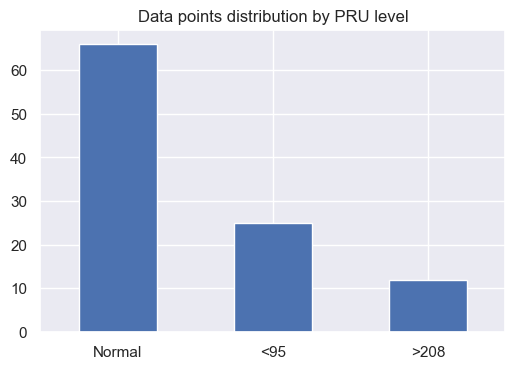

In [34]:
ax = df3.PRU_outcome.value_counts().plot(kind='bar')
ax.set_title('Data points distribution by PRU level')
plt.xticks(rotation=0)

### Evaluating models

################################### Random Forest ###################################
Confusion matrix, without normalization
[[ 7  1 17]
 [ 0  3  9]
 [ 4  1 61]]


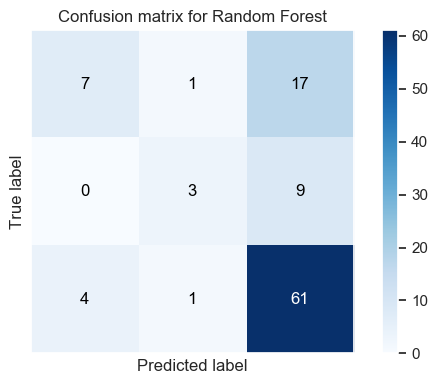

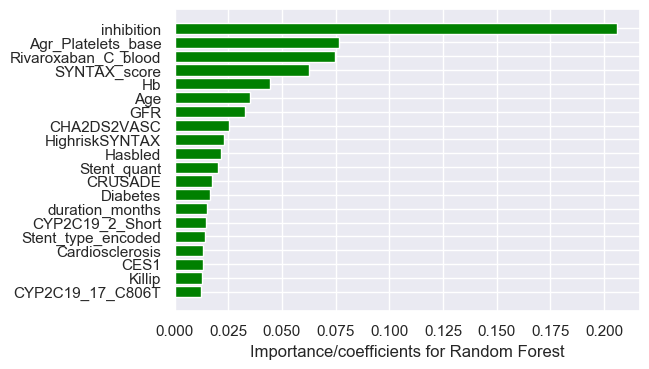

<Figure size 1000x700 with 0 Axes>

################################### SVC ###################################
Confusion matrix, without normalization
[[21  0  4]
 [ 0  7  5]
 [ 4  3 59]]


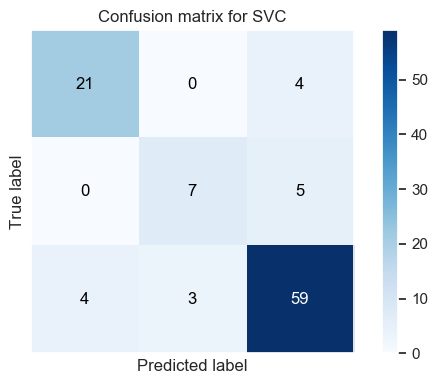

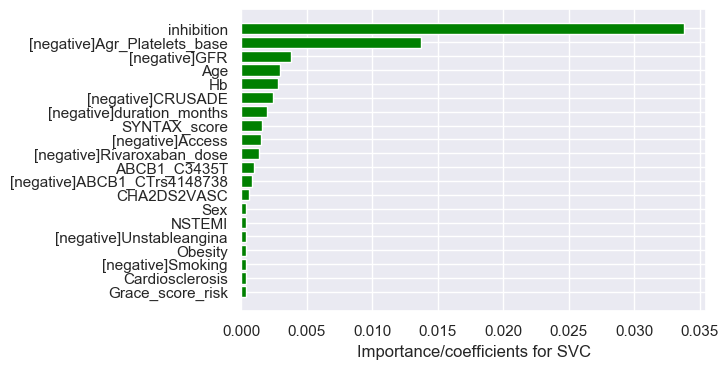

<Figure size 1000x700 with 0 Axes>

################################### Logistic Regression ###################################


/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python

/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/alexandershein/anaconda3/lib/python

/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python

/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/User

/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/alexandershein/anaconda3/lib/python

/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/alexandershein/anaconda3/lib/python

Confusion matrix, without normalization
[[21  0  4]
 [ 0  6  6]
 [ 3  1 62]]


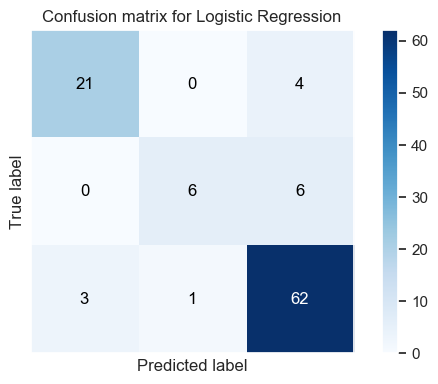

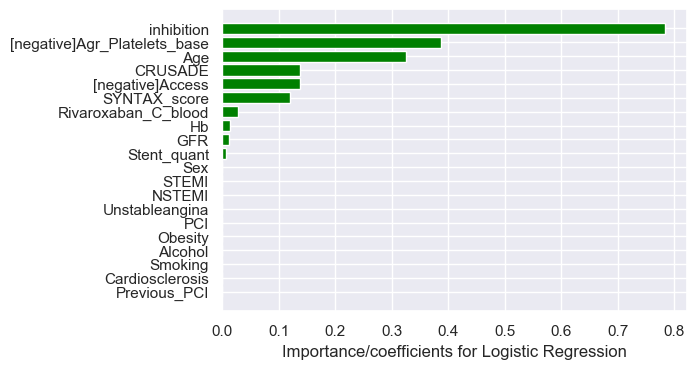

<Figure size 1000x700 with 0 Axes>

In [35]:
rf = RandomForestClassifier(n_jobs=6, n_estimators=50, random_state=random_state)
svc = SVC(kernel='linear', random_state=random_state)
log_reg = LogisticRegression(random_state=random_state, penalty='l1', solver='liblinear') # Use LASSO regularizer
for name, model in [
    ['Random Forest', rf],
    ['SVC', svc],
    ['Logistic Regression', log_reg],
]:
    print(f'{"#"*35} {name} {"#"*35}')
    evaluate_with_conf_matrix_loocv(model, X, Y, name, CLASS_NAMES,)
    plot_important_features(
        X,
        model.coef_[0] if 'Random Forest' not in name else model.feature_importances_,
        name,
    )

## [Concentration higher/lower than 137] classification - using LOOCV

### Outcome column generation


In [36]:
df4 = preprocessed_classification_df.copy(deep=True)

def process_row_outcomes(row):
    if row.Rivaroxaban_C_blood <= 137 :
        outcome = '<=137'
    else:
        outcome = '>137'
    return outcome


df4['C_rivar_137_outcome'] = df.apply(
    process_row_outcomes,
    axis = 1
)
encoder = LabelEncoder()
df4['C_rivar_137_outcome_encoded'] = encoder.fit_transform(df4.C_rivar_137_outcome)

df4 = df4.drop([col for col in df4.columns if col.startswith('Outcome')] + ['Rivaroxaban_C_blood'], axis=1)

X = df4[[col for col in df4.columns if not col.startswith('C_rivar')]]
Y = df4['C_rivar_137_outcome_encoded']
CLASS_NAMES = encoder.classes_


(array([0, 1]), <a list of 2 Text xticklabel objects>)

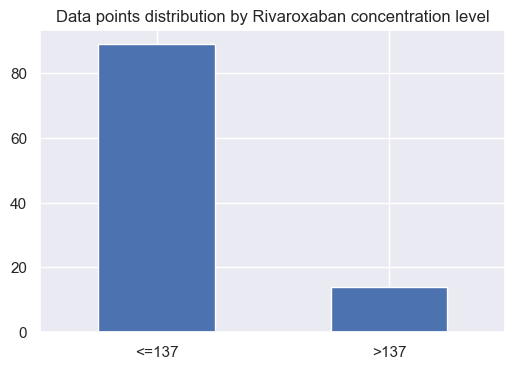

In [37]:
ax = df4.C_rivar_137_outcome.value_counts().plot(kind='bar')
ax.set_title('Data points distribution by Rivaroxaban concentration level')
plt.xticks(rotation=0)

In [38]:
df4.columns

Index(['Sex', 'Age', 'Agr_Platelets_base', 'inhibition', 'PRU', 'STEMI',
       'NSTEMI', 'Unstableangina', 'PCI', 'Obesity', 'Alcohol', 'Smoking',
       'Cardiosclerosis', 'Previous_PCI', 'PreviousCABG', 'Access',
       'Stent_quant', 'HighriskSYNTAX', 'Grace_score_risk', 'SYNTAX_score',
       'CRUSADE', 'Killip', 'Heart_Stop', 'Hypertension',
       'HeartFailure_before', 'Stroke', 'Previous_thromboses', 'Diabetes',
       'PAD', 'COPD', 'Onco', 'Previous_bleeding', 'Anaemialessthan100',
       'Plateletslessthan100', 'Highplateletsondischarge', 'RenalFailure',
       'HeartFailure', 'HasBLED39', 'DAPT_TAPT', 'Hb', 'GFR', 'CHA2DS2VASC',
       'Hasbled', 'duration_months', 'Rivaroxaban_dose', 'CYP3A4_22',
       'ABCB1_С3435Т', 'ABCB1_СТrs4148738', 'CYP2C19_2_G681A',
       'CYP2C19_17_C806T', 'CYP3A5_3_A6986G', 'ABCB1_3435_Short',
       'ABCB1_rs4148738_Short', 'CYP2C19_2_Short', 'CYP2C19_17_Short', 'CES1',
       'CYP3A4_2242480', 'PON1', 'IGTB3', 'PEAR1_rs41273215',
       'AF

### Evaluating models

################################### Random Forest ###################################
Confusion matrix, without normalization
[[89  0]
 [14  0]]


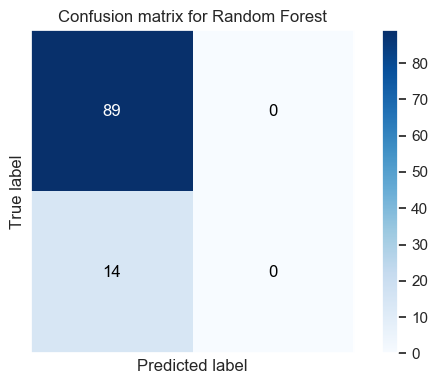

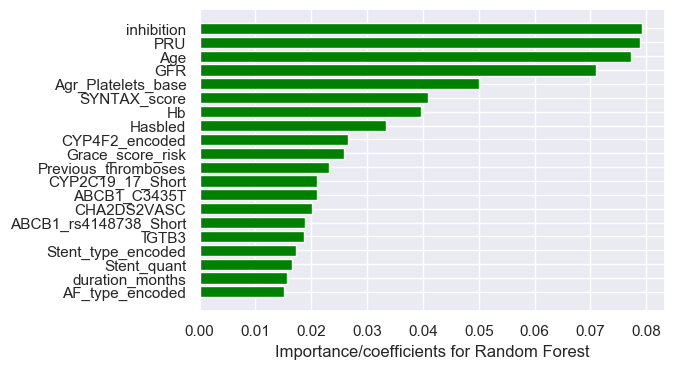

<Figure size 1000x700 with 0 Axes>

################################### SVC ###################################
Confusion matrix, without normalization
[[74 15]
 [12  2]]


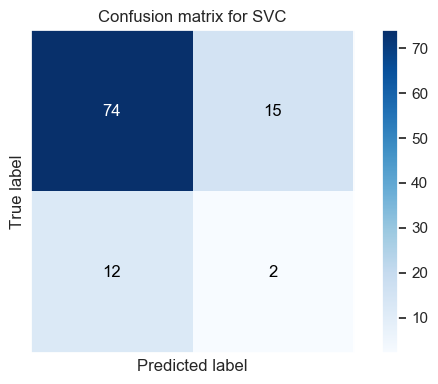

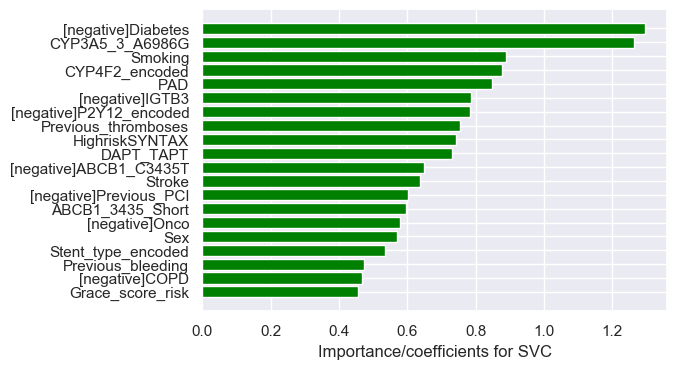

<Figure size 1000x700 with 0 Axes>

################################### Logistic Regression ###################################
Confusion matrix, without normalization
[[82  7]
 [14  0]]


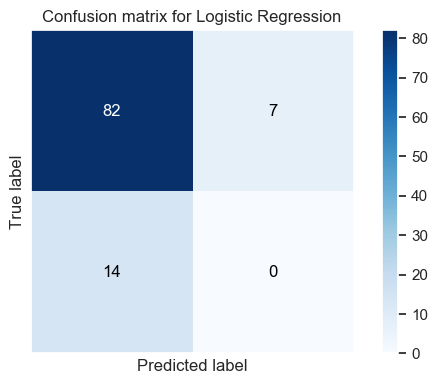

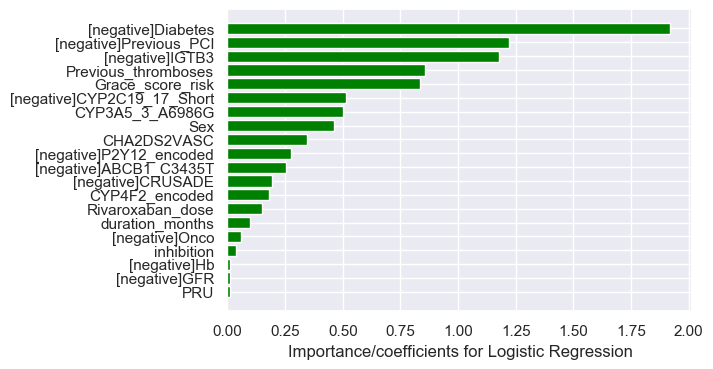

<Figure size 1000x700 with 0 Axes>

In [39]:
rf = RandomForestClassifier(n_jobs=6, n_estimators=50, random_state=random_state)
svc = SVC(kernel='linear', random_state=random_state)
log_reg = LogisticRegression(random_state=random_state, penalty='l1', solver='liblinear') # Use LASSO regularizer
for name, model in [
    ['Random Forest', rf],
    ['SVC', svc],
    ['Logistic Regression', log_reg],
]:
    print(f'{"#"*35} {name} {"#"*35}')
    evaluate_with_conf_matrix_loocv(model, X, Y, name, CLASS_NAMES,)
    plot_important_features(
        X,
        model.coef_[0] if 'Random Forest' not in name else model.feature_importances_,
        name,
    )

## [Concentration higher/lower than 39] classification - using LOOCV

### Outcome column generation


In [40]:
df5 = preprocessed_classification_df.copy(deep=True)

def process_row_outcomes(row):
    if row.Rivaroxaban_C_blood <= 39 :
        outcome = '<=39'
    else:
        outcome = '>39'
    return outcome


df5['C_rivar_39_outcome'] = df.apply(
    process_row_outcomes,
    axis = 1
)
encoder = LabelEncoder()
df5['C_rivar_39_outcome_encoded'] = encoder.fit_transform(df5.C_rivar_39_outcome)

df5 = df5.drop([col for col in df5.columns if col.startswith('Outcome')] + ['Rivaroxaban_C_blood'], axis=1)

X = df5[[col for col in df5.columns if not col.startswith('C_rivar')]]
Y = df5['C_rivar_39_outcome_encoded']
CLASS_NAMES = encoder.classes_


(array([0, 1]), <a list of 2 Text xticklabel objects>)

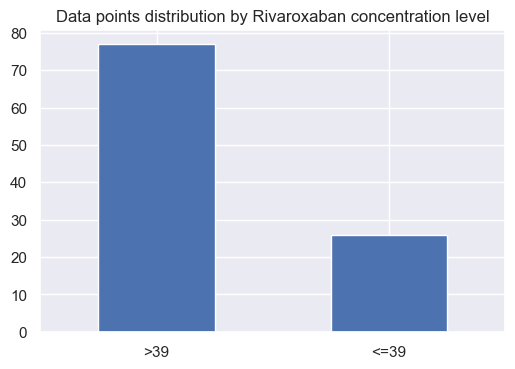

In [41]:
ax = df5.C_rivar_39_outcome.value_counts().plot(kind='bar')
ax.set_title('Data points distribution by Rivaroxaban concentration level')
plt.xticks(rotation=0)

In [42]:
df5.columns

Index(['Sex', 'Age', 'Agr_Platelets_base', 'inhibition', 'PRU', 'STEMI',
       'NSTEMI', 'Unstableangina', 'PCI', 'Obesity', 'Alcohol', 'Smoking',
       'Cardiosclerosis', 'Previous_PCI', 'PreviousCABG', 'Access',
       'Stent_quant', 'HighriskSYNTAX', 'Grace_score_risk', 'SYNTAX_score',
       'CRUSADE', 'Killip', 'Heart_Stop', 'Hypertension',
       'HeartFailure_before', 'Stroke', 'Previous_thromboses', 'Diabetes',
       'PAD', 'COPD', 'Onco', 'Previous_bleeding', 'Anaemialessthan100',
       'Plateletslessthan100', 'Highplateletsondischarge', 'RenalFailure',
       'HeartFailure', 'HasBLED39', 'DAPT_TAPT', 'Hb', 'GFR', 'CHA2DS2VASC',
       'Hasbled', 'duration_months', 'Rivaroxaban_dose', 'CYP3A4_22',
       'ABCB1_С3435Т', 'ABCB1_СТrs4148738', 'CYP2C19_2_G681A',
       'CYP2C19_17_C806T', 'CYP3A5_3_A6986G', 'ABCB1_3435_Short',
       'ABCB1_rs4148738_Short', 'CYP2C19_2_Short', 'CYP2C19_17_Short', 'CES1',
       'CYP3A4_2242480', 'PON1', 'IGTB3', 'PEAR1_rs41273215',
       'AF

### Evaluating models

################################### Random Forest ###################################
Confusion matrix, without normalization
[[ 0 26]
 [ 6 71]]


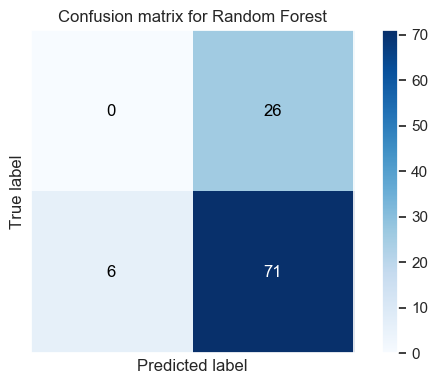

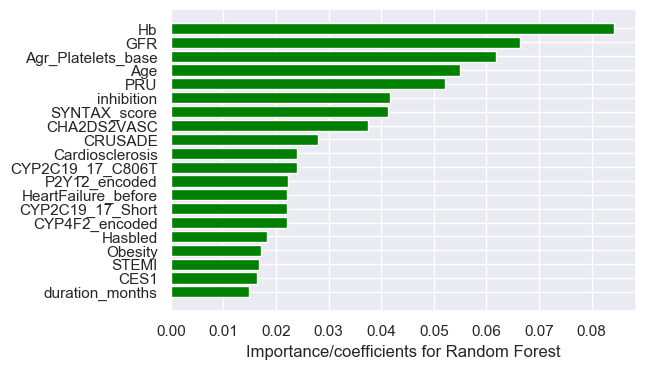

<Figure size 1000x700 with 0 Axes>

################################### SVC ###################################
Confusion matrix, without normalization
[[ 6 20]
 [22 55]]


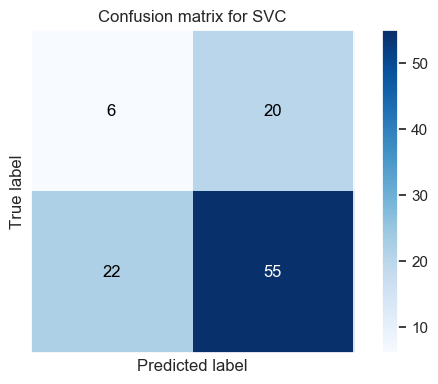

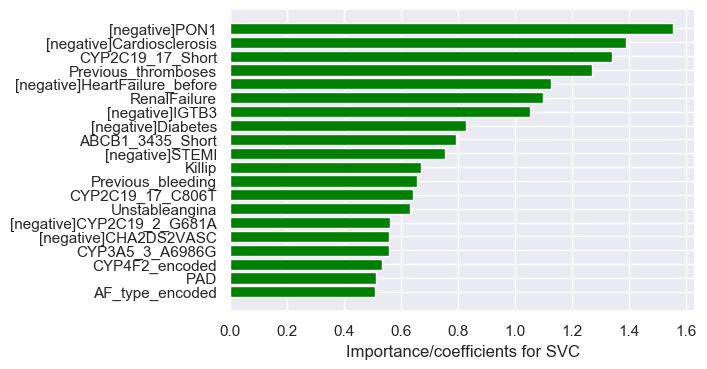

<Figure size 1000x700 with 0 Axes>

################################### Logistic Regression ###################################
Confusion matrix, without normalization
[[ 5 21]
 [16 61]]


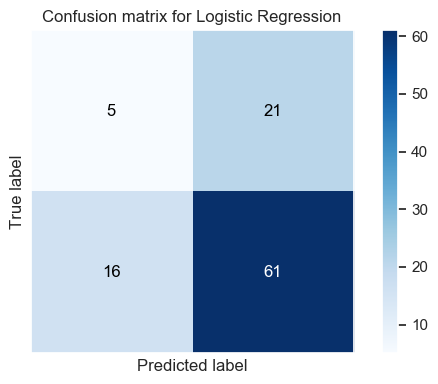

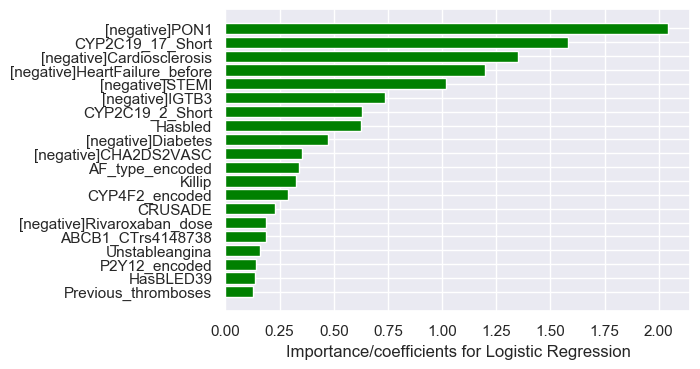

<Figure size 1000x700 with 0 Axes>

In [43]:
rf = RandomForestClassifier(n_jobs=6, n_estimators=50, random_state=random_state)
svc = SVC(kernel='linear', random_state=random_state)
log_reg = LogisticRegression(random_state=random_state, penalty='l1', solver='liblinear') # Use LASSO regularizer
for name, model in [
    ['Random Forest', rf],
    ['SVC', svc],
    ['Logistic Regression', log_reg],
]:
    print(f'{"#"*35} {name} {"#"*35}')
    evaluate_with_conf_matrix_loocv(model, X, Y, name, CLASS_NAMES,)
    plot_important_features(
        X,
        model.coef_[0] if 'Random Forest' not in name else model.feature_importances_,
        name,
    )

## Survived/died Outcomes analysis

Text(0.5, 1.0, 'GFR grouped by outcome')

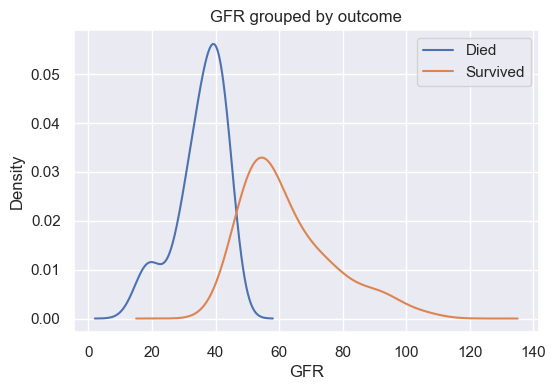

In [44]:
fig, ax = plt.subplots()
df2.groupby("Outcome").GFR.plot(kind='kde')
ax.legend(["Died", "Survived"])
ax.set_xlabel('GFR')
ax.set_title('GFR grouped by outcome')

Text(0.5, 1.0, 'Age grouped by outcome')

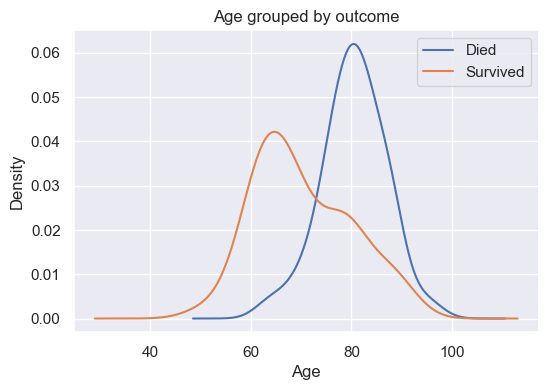

In [45]:
fig, ax = plt.subplots()
df2.groupby("Outcome").Age.plot(kind='kde')
ax.legend(["Died", "Survived"])
ax.set_xlabel('Age')
ax.set_title('Age grouped by outcome')

Text(0.5, 1.0, 'Age/GFR grouped by outcome')

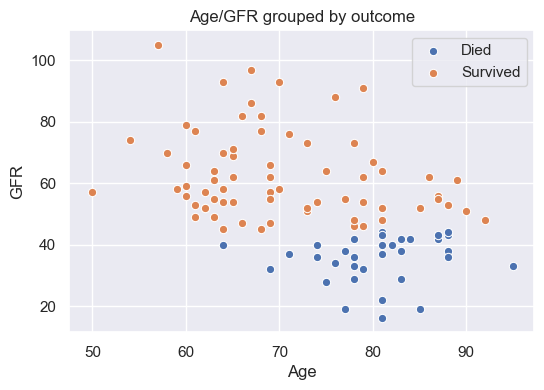

In [46]:
fig, ax = plt.subplots()
df_Age_GFR = df2[df2.Outcome_encoded == 0][['Age', 'GFR']]
sns.scatterplot(x='Age', y='GFR', data=df_Age_GFR)
df_Age_GFR = df2[df2.Outcome_encoded == 1][['Age', 'GFR']]
sns.scatterplot(x='Age', y='GFR', data=df_Age_GFR)
ax.legend(["Died", "Survived"])
ax.set_title('Age/GFR grouped by outcome')

Text(0.5, 1.0, 'CRUSADE grouped by outcome')

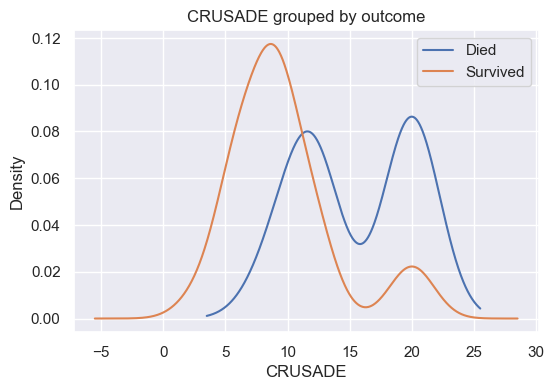

In [47]:
fig, ax = plt.subplots()
df2.groupby("Outcome").CRUSADE.plot(kind='kde')
ax.legend(["Died", "Survived"])
ax.set_xlabel('CRUSADE')
ax.set_title('CRUSADE grouped by outcome')

Text(0.5, 1.0, 'SYNTAX_score grouped by outcome')

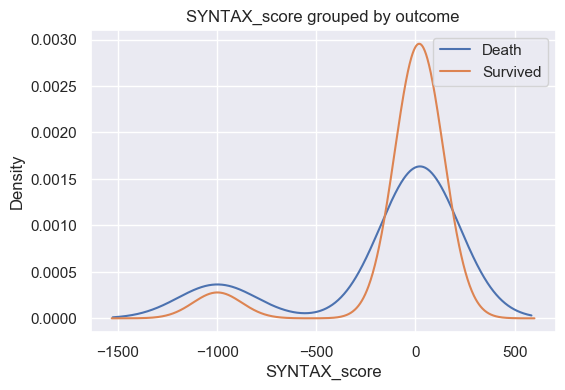

In [48]:
fig, ax = plt.subplots()
df2.groupby("Outcome").SYNTAX_score.plot(kind='kde')
ax.legend(["Death", "Survived"])
ax.set_xlabel('SYNTAX_score')
ax.set_title('SYNTAX_score grouped by outcome')

Text(0.5, 1.0, 'PRU grouped by outcome')

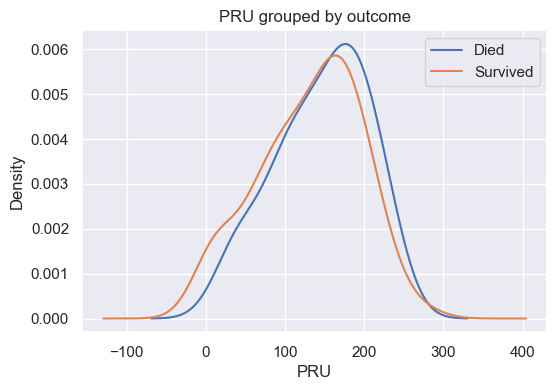

In [49]:
fig, ax = plt.subplots()
df2.groupby("Outcome").PRU.plot(kind='kde')
ax.legend(["Died", "Survived"])
ax.set_xlabel('PRU')
ax.set_title('PRU grouped by outcome')

Text(0.5, 1.0, 'Hb grouped by outcome')

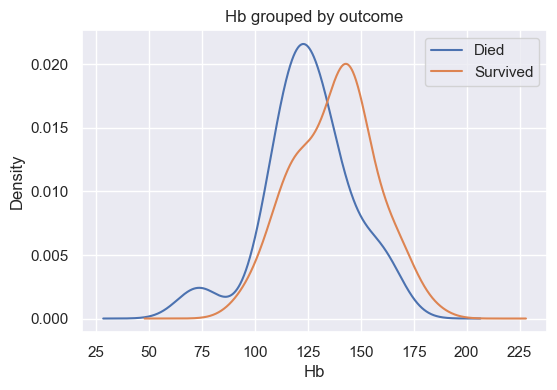

In [50]:
fig, ax = plt.subplots()
df2.groupby("Outcome").Hb.plot(kind='kde')
ax.legend(["Died", "Survived"])
ax.set_xlabel('Hb')
ax.set_title('Hb grouped by outcome')


Text(0.5, 1.0, 'Rivaroxaban_C_blood grouped by outcome')

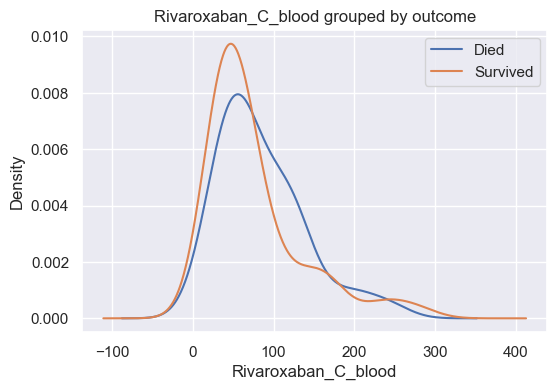

In [51]:
fig, ax = plt.subplots()
df2.groupby("Outcome").Rivaroxaban_C_blood.plot(kind='kde')
ax.legend(["Died", "Survived"])
ax.set_xlabel('Rivaroxaban_C_blood')
ax.set_title('Rivaroxaban_C_blood grouped by outcome')

# Task number 2

Concentration prediction

Target column -> `Rivaroxaban_C_blood`

## Removing outcome and missing values columns 

In [52]:
df3 = df[
    [
        col for col in df.columns
        if not col in [
            *OUTCOMES,
            *STRING_COLUMNS,
            *SUSPICIOUS_MISSING_VALUES_COLUMNS,
            *AMBIGUOUS_COLUMNS,
            *['Outcome',]
        ]
    ]
]
df3 = df3.replace(' ', 0)

X_reg = df3[[col for col in df3.columns if not col in ['Rivaroxaban_C_blood', 'C_rivar_137']]]
# Leaving only numeric or binary columns
X_reg = X_reg[[col for col in X_reg.columns if col in [*NUMERIC_COLUMNS, *BINARY_VALUES_COLUMNS]]]
Y_reg = df3.Rivaroxaban_C_blood


## Compute baseline error - simple average prediction

In [53]:
from sklearn.metrics import mean_squared_error

Y_avg = np.full(Y_reg.shape[0], Y_reg.mean())
baseline_mse = mean_squared_error(Y_reg, Y_avg)
baseline_mse

3257.379583372608

## Validating models

In [54]:
regression_models = [
    ['lasso alpha 1', linear_model.Lasso(alpha=1, random_state=random_state)],
    ['lasso alpha 100', linear_model.Lasso(alpha=100, random_state=random_state)],
    ['SVR', SVR(kernel='linear')],
    ['RF reg 2 50', RandomForestRegressor(max_depth=2, random_state=random_state, n_estimators=50)],
    ['RF reg 4 100', RandomForestRegressor(max_depth=4, random_state=random_state, n_estimators=100)],
    ['PLS 2 comp', PLSRegression(n_components=2)],
    ['PLS 1 comp', PLSRegression(n_components=1)],

]


In [55]:
def evaluate_regression_model(model, X, Y, model_name):
    kfold = KFold(n_splits=10)

    mse_s_over_folds = []
    predictions = []
    for train, test in kfold.split(X):
        Y_pred = model.fit(X.iloc[train], Y.iloc[train]).predict(X.iloc[test])
        mse_s_over_folds.append(mean_squared_error(Y.iloc[test], Y_pred))
        predictions.extend(Y_pred)
    ax = sns.lineplot(
        x=np.arange(0,10), y=mse_s_over_folds, 
    )
    ax.set_label(model_name)
    ax.set_title(f'MSE metric by folds')
    print(f'Resulting MSE for {model_name} is {sum(mse_s_over_folds)/10:.2f}')
    print(f'Resulting overall r_squared for {model_name} is {r2_score(Y, predictions):.2f}')
    return predictions

Resulting MSE for lasso alpha 1 is 4908.55
Resulting overall r_squared for lasso alpha 1 is -0.51
Resulting MSE for lasso alpha 100 is 3320.62
Resulting overall r_squared for lasso alpha 100 is -0.02
Resulting MSE for SVR is 4087.61
Resulting overall r_squared for SVR is -0.26
Resulting MSE for RF reg 2 50 is 3350.17
Resulting overall r_squared for RF reg 2 50 is -0.03
Resulting MSE for RF reg 4 100 is 3295.88
Resulting overall r_squared for RF reg 4 100 is -0.02
Resulting MSE for PLS 2 comp is 4362.57
Resulting overall r_squared for PLS 2 comp is -0.35
Resulting MSE for PLS 1 comp is 3652.77
Resulting overall r_squared for PLS 1 comp is -0.12


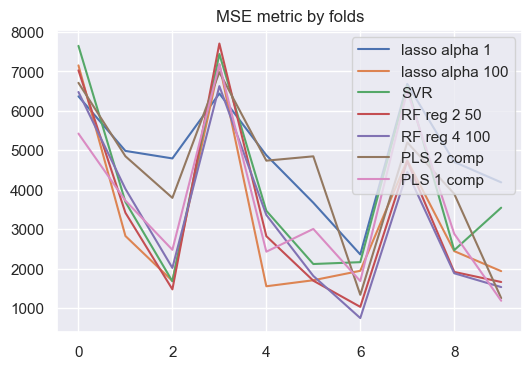

In [56]:
for model_name, model in regression_models:
    evaluate_regression_model(model, X_reg, Y_reg, model_name)
plt.legend([i[0] for i in regression_models])

In [57]:
X_reg.columns

Index(['Sex', 'Age', 'Agr_Platelets_base', 'inhibition', 'PRU', 'STEMI',
       'NSTEMI', 'Unstableangina', 'PCI', 'Obesity', 'Alcohol', 'Smoking',
       'Cardiosclerosis', 'Previous_PCI', 'PreviousCABG', 'HighriskSYNTAX',
       'Grace_score_risk', 'CRUSADE', 'Heart_Stop', 'Hypertension',
       'HeartFailure_before', 'Stroke', 'Previous_thromboses', 'Diabetes',
       'PAD', 'COPD', 'Onco', 'Previous_bleeding', 'Anaemialessthan100',
       'Plateletslessthan100', 'Highplateletsondischarge', 'RenalFailure',
       'HeartFailure', 'HasBLED39', 'DAPT_TAPT', 'Hb', 'GFR', 'CHA2DS2VASC',
       'Hasbled', 'Rivaroxaban_dose', 'CYP3A4_22', 'CYP3A5_3_A6986G',
       'ABCB1_3435_Short', 'ABCB1_rs4148738_Short', 'CYP2C19_2_Short',
       'CYP2C19_17_Short', 'CES1', 'CYP3A4_2242480', 'PON1', 'IGTB3',
       'PEAR1_rs41273215'],
      dtype='object')

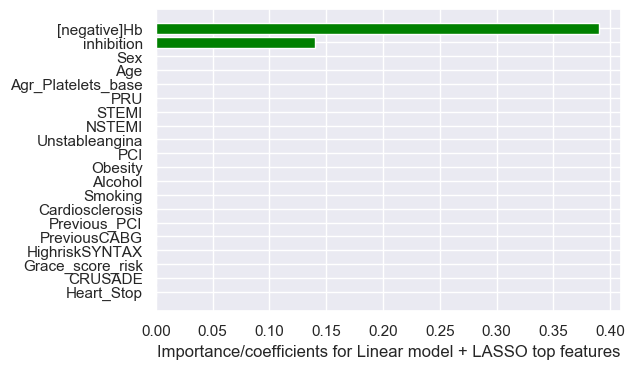

<Figure size 1000x700 with 0 Axes>

In [58]:
lasso_reg = linear_model.Lasso(alpha=100, random_state=random_state)
lasso_reg.fit(X_reg, Y_reg)
plot_important_features(X_reg, lasso_reg.coef_, 'Linear model + LASSO top features')


## Using PCA to reduce dimensions 

In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pd.DataFrame(pca.fit_transform(X_reg))

Resulting MSE for lasso alpha 1 is 3385.99
Resulting overall r_squared for lasso alpha 1 is -0.05
Resulting MSE for lasso alpha 100 is 3326.92
Resulting overall r_squared for lasso alpha 100 is -0.03
Resulting MSE for SVR is 3717.72
Resulting overall r_squared for SVR is -0.15
Resulting MSE for RF reg 2 50 is 3499.79
Resulting overall r_squared for RF reg 2 50 is -0.08
Resulting MSE for RF reg 4 100 is 3840.25
Resulting overall r_squared for RF reg 4 100 is -0.18
Resulting MSE for PLS 2 comp is 3386.68
Resulting overall r_squared for PLS 2 comp is -0.05
Resulting MSE for PLS 1 comp is 3389.08
Resulting overall r_squared for PLS 1 comp is -0.05


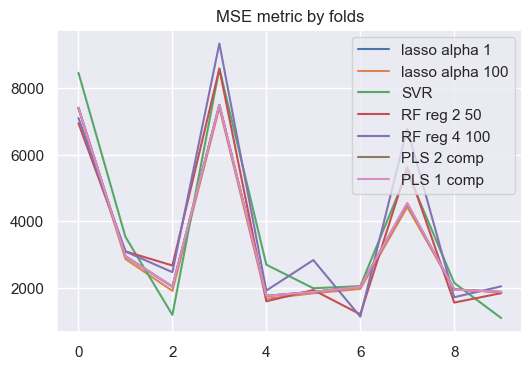

In [60]:
results = {}
for model_name, model in regression_models:
    predictions = evaluate_regression_model(model, X_pca, Y_reg, model_name)
    results[model_name] = predictions
plt.legend([i[0] for i in regression_models])

In [61]:
pca1 = PCA(n_components=1)
X_pca1 = pd.DataFrame(pca1.fit_transform(X_reg))

Resulting MSE for lasso alpha 1 is 3436.82
Resulting overall r_squared for lasso alpha 1 is -0.06
Resulting MSE for lasso alpha 100 is 3373.34
Resulting overall r_squared for lasso alpha 100 is -0.04
Resulting MSE for SVR is 3807.99
Resulting overall r_squared for SVR is -0.17
Resulting MSE for RF reg 2 50 is 3570.03
Resulting overall r_squared for RF reg 2 50 is -0.11
Resulting MSE for RF reg 4 100 is 3990.94
Resulting overall r_squared for RF reg 4 100 is -0.23


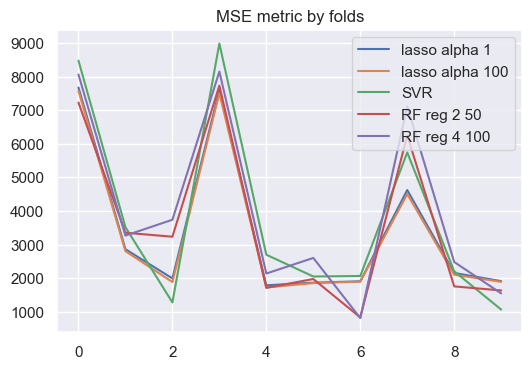

In [62]:
results = {}
for model_name, model in regression_models[:-2]:
    predictions = evaluate_regression_model(model, X_pca1, Y_reg, model_name)
    results[model_name] = predictions
plt.legend([i[0] for i in regression_models])

## Regression Summary:
All models trained both using raw dataset and PCA showed worse performance than simply predicting average all the time

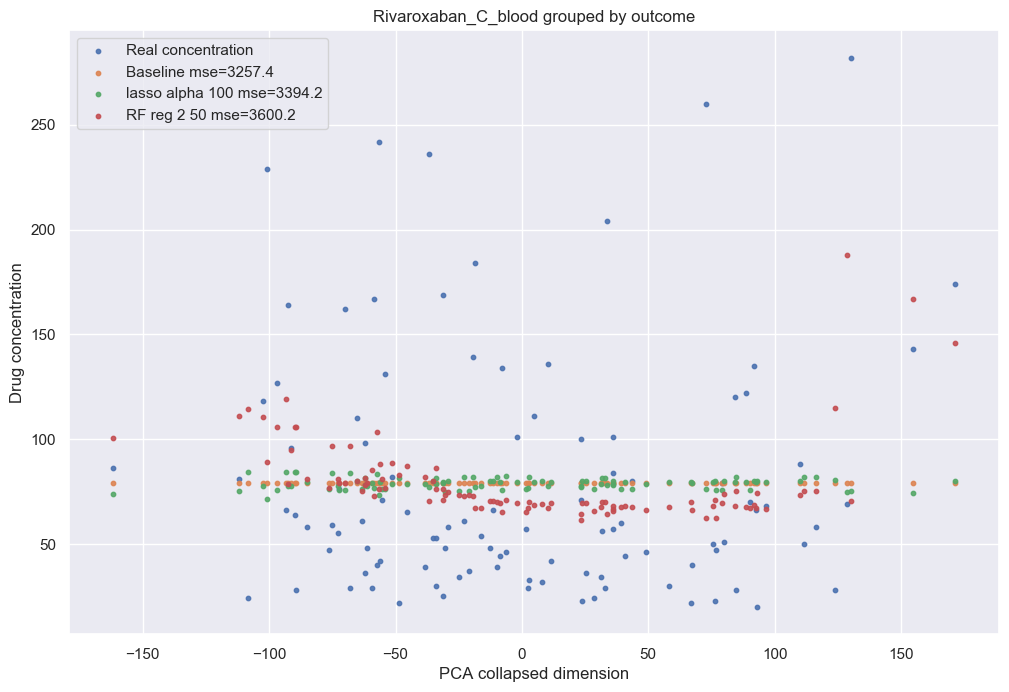

In [63]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
plt.scatter(X_pca1, Y_reg, alpha=0.9, s=10)
plt.scatter(X_pca1, Y_avg, alpha=0.9, s=10)
# plt.scatter(X_pca1, results['RF reg 2 50'], alpha=0.9, s=10)

legend = [
    'Real concentration',
    f'Baseline mse={baseline_mse:.1f}',
]
for model in ['lasso alpha 100', 'RF reg 2 50']:
    plt.scatter(X_pca1, results[model], alpha=0.9, s=10)
    mse = mean_squared_error(results[model], Y_reg)
    legend.append(f'{model} mse={mse:.1f}')

ax.set_xlabel('PCA collapsed dimension')
ax.set_ylabel('Drug concentration')
ax.set_title('Rivaroxaban_C_blood grouped by outcome')
plt.legend(legend)



In [64]:
## Visualize errors distribution

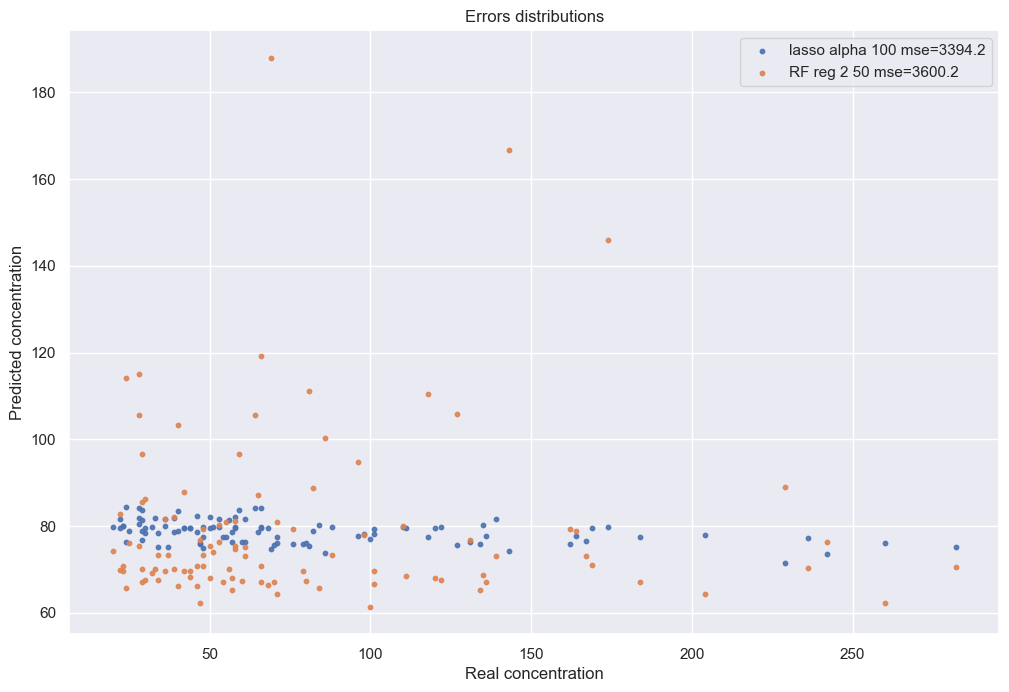

In [65]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
# plt.scatter(Y_avg, Y_reg, alpha=0.9, s=10)

legend = [
#     f'Baseline mse={baseline_mse:.1f}',
]
for model in ['lasso alpha 100', 'RF reg 2 50']:
    plt.scatter(Y_reg, results[model], alpha=0.9, s=10)
    mse = mean_squared_error(results[model], Y_reg)
    legend.append(f'{model} mse={mse:.1f}')

ax.set_ylabel('Predicted concentration')
ax.set_xlabel('Real concentration')
ax.set_title('Errors distributions')
plt.legend(legend)



## Visualize dots using 2-dimensional PCA

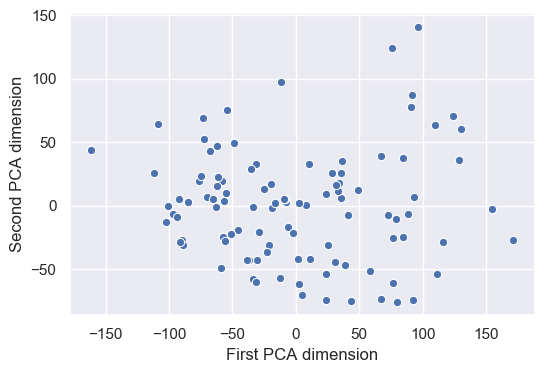

In [66]:
X_pca.columns = ['First PCA dimension', 'Second PCA dimension']
ax = sns.scatterplot(x='First PCA dimension', y='Second PCA dimension', data=X_pca)

In [67]:
df_vars = pd.DataFrame(pca.components_, columns=X_reg.columns, index=['PC-1','PC-2'])
df_vars

,Sex,Age,Agr_Platelets_base,inhibition,PRU,STEMI,NSTEMI,Unstableangina,PCI,Obesity,...,CYP3A5_3_A6986G,ABCB1_3435_Short,ABCB1_rs4148738_Short,CYP2C19_2_Short,CYP2C19_17_Short,CES1,CYP3A4_2242480,PON1,IGTB3,PEAR1_rs41273215
PC-1,-0.000911,-0.028742,-0.367024,0.303762,-0.873784,-0.001098,0.000064,0.000960,-0.000071,0.000707,...,0.000286,-0.000037,-0.001084,-0.000474,0.001205,0.000766,-0.000570,-0.000134,-0.000253,0.000424
PC-2,0.002874,0.053779,0.868158,0.379076,-0.254453,0.000945,-0.000676,-0.000486,-0.000885,-0.001601,...,-0.000797,0.000652,0.000966,-0.000897,0.002295,0.000582,0.000407,0.000354,0.001515,-0.000955


## Figure out optimal alpha for LASSO using GridSearchCV


In [68]:
tuned_parameters = [{'alpha': np.arange(10, 1010, 10)}]
clf = GridSearchCV(
    linear_model.Lasso(alpha=1, random_state=random_state),
    tuned_parameters,
    cv=5,
    scoring=make_scorer(mean_squared_error, greater_is_better=False)
)
clf.fit(X_reg, Y_reg,)
clf.best_params_

/Users/alexandershein/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 590}

Resulting MSE for Lasso with huge alpha is 3305.74
Resulting overall r_squared for Lasso with huge alpha is -0.02


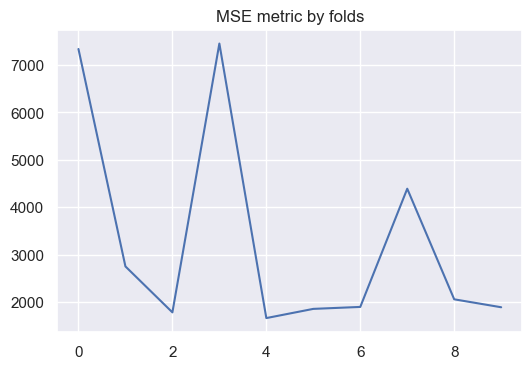

In [69]:
lasso_huge_alpha = linear_model.Lasso(alpha=590, random_state=random_state)
_ = evaluate_regression_model(
    lasso_huge_alpha,
    X_reg,
    Y_reg,
    'Lasso with huge alpha'
)

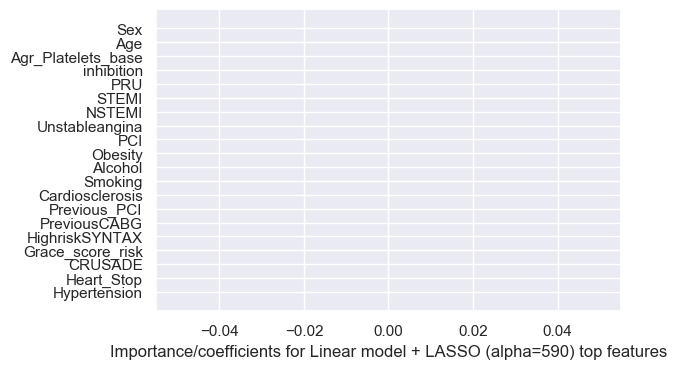

<Figure size 1000x700 with 0 Axes>

In [70]:
plot_important_features(X_reg, lasso_huge_alpha.coef_, 'Linear model + LASSO (alpha=590) top features')


In [71]:
lasso_huge_alpha.coef_

array([ 0.,  0.,  0.,  0., -0., -0.,  0.,  0., -0.,  0.,  0.,  0., -0.,
       -0., -0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0., -0.,
       -0.,  0.,  0., -0., -0.,  0.,  0.,  0., -0., -0., -0.,  0.,  0.,
       -0.,  0.,  0., -0.,  0.,  0., -0.,  0., -0., -0., -0., -0.])

Looks like the smallest mse is shown, when all predictions are zeroes.